# 프로젝트: 한국어 데이터로 챗봇 만들기
⭐️ 한국어 전처리를 통해 학습 데이터셋을 구축하였다. 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.  
⭐️ 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.  
⭐️ 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. 한국어 입력문장에 맥락에 맞는 한국어로 답변을 리턴하였다.

---
## 🤖 Import libraries & packages

In [1]:
# import useful tools
import os
import re
from random import randint


# import data tools
import numpy as np


# import visualization tool
import matplotlib.pyplot as plt


# import DL tools
import tensorflow as tf
import tensorflow_datasets as tfds

---
## 🤖 Define constants, frequently used variables and methods

In [2]:
# column index number of datasets
QUESTIONS = 0
ANSWERS = 1
LABELS = 2


# total samples to load from data source
TOTAL_SAMPLES_CNT = -1    # -1 : as much as possible

# maximum length of sentences in training data
MAX_SENTENCE_LEN = 40

# maximum size of vocabulary set
VOCAB_SIZE = 2**13 + 2    # +2 for start token, end token



# ML hyper parameters
BATCH_SIZE = 64
BUFFER_SIZE = 20000

NUM_LAYERS = 2    # the number of layers in encoder&decoder
D_MODEL = 256     # fixed dimension of input/output of inner encoder/decoder
NUM_HEADS = 8     # the number of heads for multihead attention 
UNITS = 512       # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1     # ratio of dropout

EPOCHS = 200



# path of data source file
data_filename = os.getenv("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv"



# frequently used methods
DIVIDER_LENGTH = 80
def print_single_divider():
    print("-" * DIVIDER_LENGTH)
    
def print_double_divider():
    print("=" * DIVIDER_LENGTH)

---
## 🤖 Prepare dataset

### 1. Define dataset loading & pre-processing methods

1-1. Define dataset loading method

In [3]:
def load_chat_dataset(data_filename = data_filename, limit = TOTAL_SAMPLES_CNT): 
    # read data from ChatbotData.csv file
    with open(data_filename, "r") as file:
        data_source = file.readlines()
    
    # set maximum number of sample data
    if limit == -1:
        limit = len(data_source) - 1

        
    # split one sample data into Q, A, label part
    data = {"Q": [], "A": [], "label": []}
    for idx, sample in enumerate(data_source[1:limit + 1]):    # exclude column line
        sample_split = sample.replace("\n", "").split(",")
        
        data["Q"].append(sample_split[QUESTIONS])
        data["A"].append(sample_split[ANSWERS])
        data["label"].append(sample_split[LABELS])


    # display result
    if len(data["Q"]) == len(data["A"]) and len(data["Q"]) == len(data["label"]):
        print("Total", len(data["Q"]), "data samples are successfully loaded.")
    else:
        print("Warning! The input and target data samples are not paired successfully.")
        
    return data

1-2. Define pre-processing method (removing unnecessary characters method )

In [4]:
def divide_punctuations(sentence):
    # remove space characters in bothside
    sentence = sentence.strip()

    # insert space(" ") between words and punctuations
    #     ex. "나는 학생이다." => "나는 학생이다 ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # substitute all characters except (한글, ".", "?", "!", ",") with space(" ")
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣.?!,]+", " ", sentence)

    # remove space characters that caused by substitution by regular expressions
    sentence = sentence.strip()
    
    return sentence

1-3. Define pipeline method to load and pre-process data

In [5]:
def load_preprocess_data(data_filename = data_filename, limit = TOTAL_SAMPLES_CNT):
    # load data
    data = load_chat_dataset(data_filename, limit)
    questions = data["Q"]
    answers = data["A"]

    # pre-process data
    questions = [divide_punctuations(q) for q in questions]
    print_double_divider()
    print("Pre-processing on", len(questions), "sentences in QUESTIONS data are succesfully finished!")
    answers = [divide_punctuations(a) for a in answers]
    print("Pre-processing on", len(answers), "sentences in ANSWERS data are succesfully finished!")
    
    return questions, answers

### 2. Load and pre-process data

In [6]:
# load & pre-process data
questions, answers = load_preprocess_data()



# preview of sample data
print_double_divider()
print("< Preview of sample data >")

random_idx = randint(1, len(questions))
print_single_divider()
print("Q", random_idx, ":", questions[random_idx - 1])
print("A", random_idx, ":", answers[random_idx - 1])

random_idx = randint(1, len(questions))
print_single_divider()
print("Q", random_idx, ":", questions[random_idx - 1])
print("A", random_idx, ":", answers[random_idx - 1])

random_idx = randint(1, len(questions))
print_single_divider()
print("Q", random_idx, ":", questions[random_idx - 1])
print("A", random_idx, ":", answers[random_idx - 1])

Total 11823 data samples are successfully loaded.
Pre-processing on 11823 sentences in QUESTIONS data are succesfully finished!
Pre-processing on 11823 sentences in ANSWERS data are succesfully finished!
< Preview of sample data >
--------------------------------------------------------------------------------
Q 7276 : 용서의 의미
A 7276 : 단지 받아들였을 뿐이에요 .
--------------------------------------------------------------------------------
Q 3480 : 요즘 웃을 일이 없네
A 3480 : 억지로라도 웃어보세요 !
--------------------------------------------------------------------------------
Q 10133 : 싸우다보니까 사랑했던걸 까먹어
A 10133 : 사랑하게 된 이유를 써놓고 사랑이 힘겨울때 꺼내 읽어보세요 .


### 3. Define integer encoding & padding methods

3-1. Generate vocabulary set from data

In [7]:
# generate vocabulary set from QUESTIONS & ANSWERS data
vocab_encoder = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size = VOCAB_SIZE - 2)
    # target_vocab_size = VOCAB_SIZE - 2 (-2 for start token, end token)

print("Vocabulary encoder with total", vocab_encoder.vocab_size, "words is suceesfully generated!")

Vocabulary encoder with total 8112 words is suceesfully generated!


3-2. Assign integer value for START token and END token

In [8]:
START_TOKEN = vocab_encoder.vocab_size
END_TOKEN = vocab_encoder.vocab_size + 1

# adjust the constant value of total vocabulary size
VOCAB_SIZE = vocab_encoder.vocab_size + 2

print("Additional integer idx for START and END tokens are successfully assigned!")
print(">>> integer index of START token :", START_TOKEN)
print(">>> integer index of END token   :", END_TOKEN)

Additional integer idx for START and END tokens are successfully assigned!
>>> integer index of START token : 8112
>>> integer index of END token   : 8113


3-3. Define interger encoding & padding methods
   - 해당 프로젝트에서는 모듈화를 위해 integer encoding과 padding 기능을 분리하여 각각의 method로 정의
   - 그러나 두 기능 모두 MAX_SENTENCES_LEN과 밀접한 연관이 있어 동일한 연산을 중복 수행하게 되는 trade-off 발생
   - 연산 속도가 중요한 경우에는 encoding & padding 기능을 동시에 수행함으로써 중복 연산을 최소화할 것을 제안

In [9]:
def integer_encode_strings(sentences):
    encoded_sentences = []
    
    for s in sentences:
        encoded_sentences.append([START_TOKEN] + vocab_encoder.encode(s) + [END_TOKEN])
        
    return encoded_sentences

In [10]:
def filter_pad_data_pair(encoded_source_sentences, encoded_target_sentences, limit = MAX_SENTENCE_LEN):
    
    # filter over-length data
    filtered_source_sentences = []
    filtered_target_sentences = []
    for source_s, target_s in zip(encoded_source_sentences, encoded_target_sentences):
        if len(source_s) <= limit and len(target_s) <= limit:
            filtered_source_sentences.append(source_s)
            filtered_target_sentences.append(target_s)
    
    # padding length-filtered data
    padded_source_sentences = tf.keras.preprocessing.sequence.pad_sequences(
                                filtered_source_sentences,
                                maxlen = limit,
                                padding = "post")
    padded_target_sentences = tf.keras.preprocessing.sequence.pad_sequences(
                                filtered_target_sentences,
                                maxlen = limit,
                                padding = "post")
    
    return padded_source_sentences, padded_target_sentences

3-4. Define pipeline method to integer-encode and pad data

In [11]:
def encode_pad_data(source_sentences, target_sentences, limit = MAX_SENTENCE_LEN):
    # integer encoding
    encoded_source_sentences = integer_encode_strings(source_sentences)
    encoded_target_sentences = integer_encode_strings(target_sentences)
    print("Total", len(encoded_source_sentences), "samples are successfully encoded as vocabulary indices.")
    
    # filter over-length data & padding
    padded_source_sentences, encoded_target_sentences = filter_pad_data_pair(encoded_source_sentences, encoded_target_sentences, limit)
    print("Total", len(padded_source_sentences), "samples are successfully padded as", limit, "length.")
    
    return padded_source_sentences, encoded_target_sentences

### 4. Integer-encode and pad data 

In [12]:
source_data, target_data = encode_pad_data(questions, answers)

# preview of encoded sample data
print_double_divider()
print("< Preview of sample data >")

random_idx = randint(1, len(source_data))
print_single_divider()
print("Q", random_idx, ":", source_data[random_idx - 1])
print("A", random_idx, ":", target_data[random_idx - 1])

random_idx = randint(1, len(questions))
print_single_divider()
print("Q", random_idx, ":", source_data[random_idx - 1])
print("A", random_idx, ":", target_data[random_idx - 1])

random_idx = randint(1, len(questions))
print_single_divider()
print("Q", random_idx, ":", source_data[random_idx - 1])
print("A", random_idx, ":", target_data[random_idx - 1])

Total 11823 samples are successfully encoded as vocabulary indices.
Total 11823 samples are successfully padded as 40 length.
< Preview of sample data >
--------------------------------------------------------------------------------
Q 10198 : [8112   61  196   42 5579 7888  114   23 1180 1572    1 8113    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
A 10198 : [8112 5055 7888  514  108  238 5875    1 8113    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
--------------------------------------------------------------------------------
Q 7052 : [8112 2244  967  552   16 4640    2 8113    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
A 7052 : [8112 3076  964  291 3063    1 8113

### 5. Prepare final DataFrame to adopt teacher forcing

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((
                        {"inputs" : source_data,
                         "dec_inputs" : target_data[:, :-1]},
                        {"outputs": target_data[:, 1:]},))
    # START_TOKEN in target data removed for teacher forcing

### 6. Get ready to use data for transformer model

In [14]:
# get ready to use for transformer model
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---
## 🤖 Design transformer model

### 1. Additional pre-process for transformer input

1-1. Implement scaled-dot product attention method

In [15]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)
        
    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)
    
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

1-2. Implement masking methods

In [16]:
# masking method which create padding style masks
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


# masking method which create look-ahead style masks
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [17]:
# test operation of padding masking method
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

print_single_divider()

# test operation of look-ahead masking method
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)
--------------------------------------------------------------------------------
tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)
tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


1-3. Implement positional encoding layer class

In [18]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
                        position = tf.range(position, dtype = tf.float32)[:, tf.newaxis],
                        i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :],
                        d_model = d_model)
        
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])
        
        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis = 0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

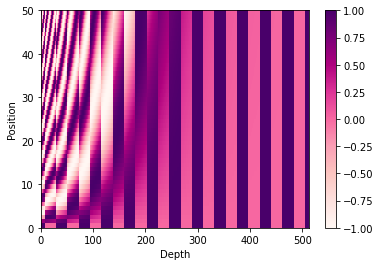

In [19]:
# test operation of positional encoding layer
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap = "RdPu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

1-4. Implement multi-head attetion layer class

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name = "multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm = [0, 2, 1, 3])
    
    
    def call(self, inputs):
        query = inputs["query"]
        key = inputs["key"]
        value = inputs["value"]
        mask = inputs["mask"]
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        
        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs

### 2. Design ENCODER structure

2-1. Implement encoding layer class

In [21]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name = "encoder_layer"):
    inputs = tf.keras.Input(shape = (None, d_model), name = "inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
                    d_model, num_heads, name = "attention")({
                        "query": inputs,
                        "key": inputs,
                        "value": inputs,
                        "mask": padding_mask})
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate = dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(inputs + attention)
    
    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units = units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention + outputs)
    
    return tf.keras.Model(inputs = [inputs, padding_mask], outputs = outputs, name = name)

2-2. Build encoder with layers

In [22]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "encoder"):
    inputs = tf.keras.Input(shape=(None,), name = "inputs")
    
    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name = "padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(units = units,
                                d_model = d_model,
                                num_heads = num_heads,
                                dropout = dropout,
                                name = "encoder_layer_{}".format(i),
                               )([outputs, padding_mask])
        
    return tf.keras.Model(inputs = [inputs, padding_mask], outputs = outputs, name = name)

### 3. Design DECODER structure

3-1. Implement decoder layer class

In [23]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name = "decoder_layer"):
    inputs = tf.keras.Input(shape = (None, d_model), name = "inputs")
    enc_outputs = tf.keras.Input(shape = (None, d_model), name = "encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape = (1, None, None), name = "look_ahead_mask")
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = 'padding_mask')
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
                    d_model, num_heads, name = "attention_1")(inputs = {
                        "query": inputs,
                        "key": inputs,
                        "value": inputs,
                        "mask": look_ahead_mask})
    
    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
                    d_model, num_heads, name = "attention_2")(inputs = {
                        "query": attention1,
                        "key": enc_outputs,
                        "value": enc_outputs,
                        "mask": padding_mask})
    
    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate = dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)
    
    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units = units, activation = "relu")(attention2)
    outputs = tf.keras.layers.Dense(units = d_model)(outputs)
    
    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate = dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs = outputs,
                          name = name)

3-2. Build decoder with layers

In [24]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "decoder"):
    inputs = tf.keras.Input(shape = (None,), name = "inputs")
    enc_outputs = tf.keras.Input(shape = (None, d_model), name = "encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape = (1, None, None), name = "look_ahead_mask")
    
    # 패딩 마스크
    padding_mask = tf.keras.Input(shape = (1, 1, None), name = "padding_mask")
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    
    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(units = units,
                                d_model = d_model,
                                num_heads = num_heads,
                                dropout = dropout,
                                name = "decoder_layer_{}".format(i),
                               )(inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])
        
    return tf.keras.Model(inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
                          outputs = outputs,
                          name = name)

## 4. Build transformer by combining each function block

In [25]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name = "transformer"):
    inputs = tf.keras.Input(shape=(None,), name = "inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name = "dec_inputs")
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
                            create_padding_mask,
                            output_shape = (1, 1, None),
                            name = "enc_padding_mask")(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
                            create_look_ahead_mask,
                            output_shape = (1, None, None),
                            name = "look_ahead_mask")(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
                            create_padding_mask,
                            output_shape = (1, 1, None),
                            name = "dec_padding_mask")(inputs)
    
    # 인코더
    enc_outputs = encoder(vocab_size = vocab_size,
                          num_layers = num_layers,
                          units = units,
                          d_model = d_model,
                          num_heads = num_heads,
                          dropout = dropout,
                         )(inputs = [inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(vocab_size = vocab_size,
                          num_layers = num_layers,
                          units = units,
                          d_model = d_model,
                          num_heads = num_heads,
                          dropout = dropout,
                         )(inputs = [dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전연결층
    outputs = tf.keras.layers.Dense(units = vocab_size, name = "outputs")(dec_outputs)
    
    return tf.keras.Model(inputs = [inputs, dec_inputs], outputs = outputs, name = name)

# 일단 여기까지는 OK

## 5. Define additional functions to test transformer performance

5-1. Define loss function

In [26]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, MAX_SENTENCE_LEN - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits = True, reduction = "none")(y_true, y_pred)
    
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    
    return tf.reduce_mean(loss)

5-2. Define accuracy function

In [27]:
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, MAX_SENTENCE_LEN - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

5-3. Implement custom learning rate class

In [28]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
    
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

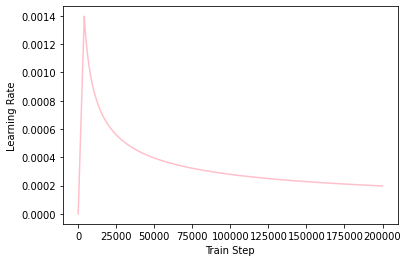

In [29]:
# test operation of custom learning rate
sample_learning_rate = CustomSchedule(d_model = 128)

fig = plt.figure()
plt.plot(sample_learning_rate(tf.range(200000, dtype = tf.float32)), color = "pink")
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

5-4. Define method to get predicted answer for input question using trained model

In [30]:
def decoder_inference(sentence):
    # pre-process of input sentence
    sentence = divide_punctuations(sentence)
    
    # integer-encode sentence & add START/END tokens
    sentence = tf.expand_dims(
        [START_TOKEN] + vocab_encoder.encode(sentence) + [END_TOKEN], axis = 0)
    
    # save past output sequence predicted by decoder
    # initial value is START_TOKEN
    output_sequence = tf.expand_dims([START_TOKEN], 0)
    
    # predict proper answer(reaction of chatbot)
    for i in range(MAX_SENTENCE_LEN):
        # keep predicting words (until the length becomes MAX_SENTNECE_LEN in maximum case)
        predictions = model(inputs = [sentence, output_sequence], training = False)
        predictions = predictions[:, -1:, :]
        
        # integer index of currently predicted word
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1), tf.int32)
        
        # stop prediction when END token is predicted
        if tf.equal(predicted_id, END_TOKEN):
            break
            
        # add predicted words to output sequence
        # output sequence might be the next input of decoder
        output_sequence = tf.concat([output_sequence, predicted_id], axis = -1)
        
    return tf.squeeze(output_sequence, axis = 0)

5-5. Define method to decode integer-incoded sentence

In [31]:
def sentence_generation(sentence):
    # get encoded prediction of answer(reaction of chatbot)
    encoded_pred = decoder_inference(sentence)
    
    # decode encoded prediction (integer -> string)
    decoded_pred = vocab_encoder.decode(
                            [i for i in encoded_pred if i < VOCAB_SIZE - 2])    # exclude START/END tokens
    
    # print predicted result
    print("Your said   :", sentence)
    print("Bot replies :", decoded_pred)
    
    return decoded_pred

---
## 🤖 Experiment

### 1. Generate transformer model instance

In [32]:
tf.keras.backend.clear_session()

# generate instance of transformer model
model = transformer(vocab_size = VOCAB_SIZE, 
                    num_layers = NUM_LAYERS,
                    units = UNITS,
                    d_model = D_MODEL,
                    num_heads = NUM_HEADS,
                    dropout = DROPOUT)

# overview of model structure
print(model.summary())

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3131392     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2. Compile transformer model instance

In [33]:
# get learning rate and optimizer
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

# complie model
model.compile(optimizer = optimizer, loss = loss_function, metrics = [accuracy])

### 3. Train data

In [34]:
history = model.fit(dataset, epochs = EPOCHS, verbose = 1)

Epoch 1/200
185/185 [==============================] - 16s 52ms/step - loss: 1.4556 - accuracy: 0.0246
Epoch 2/200
185/185 [==============================] - 10s 52ms/step - loss: 1.1800 - accuracy: 0.0493
Epoch 3/200
185/185 [==============================] - 10s 52ms/step - loss: 0.9980 - accuracy: 0.0505
Epoch 4/200
185/185 [==============================] - 10s 52ms/step - loss: 0.9233 - accuracy: 0.0541
Epoch 5/200
185/185 [==============================] - 10s 52ms/step - loss: 0.8666 - accuracy: 0.0573
Epoch 6/200
185/185 [==============================] - 10s 53ms/step - loss: 0.8081 - accuracy: 0.0611
Epoch 7/200
185/185 [==============================] - 10s 53ms/step - loss: 0.7435 - accuracy: 0.0670
Epoch 8/200
185/185 [==============================] - 10s 53ms/step - loss: 0.6724 - accuracy: 0.0744
Epoch 9/200
185/185 [==============================] - 10s 53ms/step - loss: 0.5936 - accuracy: 0.0836
Epoch 10/200
185/185 [==============================] - 10s 53ms/step - l

185/185 [==============================] - 10s 54ms/step - loss: 0.0028 - accuracy: 0.1733
Epoch 80/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0029 - accuracy: 0.1733
Epoch 81/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0027 - accuracy: 0.1733
Epoch 82/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0026 - accuracy: 0.1733
Epoch 83/200
185/185 [==============================] - 10s 53ms/step - loss: 0.0028 - accuracy: 0.1733
Epoch 84/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0026 - accuracy: 0.1733
Epoch 85/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0026 - accuracy: 0.1733
Epoch 86/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0026 - accuracy: 0.1733
Epoch 87/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0026 - accuracy: 0.1733
Epoch 88/200
185/185 [==============================] - 10s 54ms/step - loss:

185/185 [==============================] - 10s 53ms/step - loss: 0.0013 - accuracy: 0.1735
Epoch 158/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0015 - accuracy: 0.1734
Epoch 159/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0012 - accuracy: 0.1735
Epoch 160/200
185/185 [==============================] - 10s 53ms/step - loss: 0.0012 - accuracy: 0.1735
Epoch 161/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0013 - accuracy: 0.1735
Epoch 162/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0013 - accuracy: 0.1735
Epoch 163/200
185/185 [==============================] - 10s 53ms/step - loss: 0.0012 - accuracy: 0.1735
Epoch 164/200
185/185 [==============================] - 10s 54ms/step - loss: 0.0011 - accuracy: 0.1735
Epoch 165/200
185/185 [==============================] - 10s 53ms/step - loss: 0.0012 - accuracy: 0.1735
Epoch 166/200
185/185 [==============================] - 10s 54ms/ste

### 4. Test trained model

In [35]:
print(">>> Welcome to my chatbot world!\n")

question = "지금 몇시야?"
answer = sentence_generation(question)

print_single_divider()
question = "오늘 점심 메뉴 추천해줘"
answer = sentence_generation(question)

print_single_divider()
question = "요즘 날씨가 너무 춥다"
answer = sentence_generation(question)

print_single_divider()
question = "주말에는 청소를 할거야"
answer = sentence_generation(question)

print_single_divider()
question = "크리스마스 선물은 뭐가 좋을까?"
answer = sentence_generation(question)

print_single_divider()
question = "인터넷 쇼핑을 했는데 얼른 택배 왔으면 좋겠다"
answer = sentence_generation(question)

print_single_divider()
question = "내일은 어떤 공부를 하게 될까?"
answer = sentence_generation(question)

print_single_divider()
question = "너는 취미가 뭐야?"
answer = sentence_generation(question)

print_single_divider()
question = "나는 고양이보다 강아지가 더 좋아"
answer = sentence_generation(question)

print_single_divider()
question = "사실은 말할 수 없는 비밀이 있어"
answer = sentence_generation(question)

print_single_divider()
question = "우리 이제는 사랑하게 될거야"
answer = sentence_generation(question)

>>> Welcome to my chatbot world!

Your said   : 지금 몇시야?
Bot replies : 간단한 견과류나 과일을 먹어보세요 .
--------------------------------------------------------------------------------
Your said   : 오늘 점심 메뉴 추천해줘
Bot replies : 누구랑 먹는 냐에 따라 다르겠죠 .
--------------------------------------------------------------------------------
Your said   : 요즘 날씨가 너무 춥다
Bot replies : 이별에는 면역이 힘든가봐요 .
--------------------------------------------------------------------------------
Your said   : 주말에는 청소를 할거야
Bot replies : 같이 안해보세요 .
--------------------------------------------------------------------------------
Your said   : 크리스마스 선물은 뭐가 좋을까?
Bot replies : 항상 못해본 건 궁금하더라고요 .
--------------------------------------------------------------------------------
Your said   : 인터넷 쇼핑을 했는데 얼른 택배 왔으면 좋겠다
Bot replies : 사이즈를 잘 보고 사세요 .
--------------------------------------------------------------------------------
Your said   : 내일은 어떤 공부를 하게 될까?
Bot replies : 기우제를 지내봅시다 !
---------------------------------------------------------

---
**회고록**  
아니...! 이렇게 자기 할 말만 하는 챗봇이라니...! 화만 돋구고 끝난 프로젝트 😤  

성능과는 별개로 언젠가 챗봇 만들어보고 싶다고만 생각하고 엄두를 못 냈는데, 너무너무 신기하다 🥹  
언젠가는 사랑하는 사람들의 말투를 담은 데이터셋을 만들어서, 나중에 만날 수 없게 되더라도 챗본과 함께 추억을 회상하고 싶다

이전에 사용자 아바타가 특정 동작을 하면, 가상 아바타가 반응 동작을 하는 연구를 한 적이 있다.  
모션 데이터베이스에서 입력/출력 동작을 찾아내는 방식이라 실전 콘텐츠에 도입하기에는 한계가 많았다.  
시간이 지나고 딥러닝의 유행이 불어오면서, 해당 연구에 딥러닝을 도입하면 성능을 더욱 개선할 수 있을거라고 제안했지만 시간이 부족해서 포기해버렸다 😒  
AI 지식이 없다보니 말로만 딥러닝 붙이면 나아질거라고 생각했지 구체적인 방안은 전혀 몰랐는데,  
각 모션 데이터마다 의미(단어 또는 문맥)를 부여하고 이렇게 transformer 를 통해 다음 동작을 예상하게 하면 되는 것 같다.

대학원에서 AI가 결합된 기술을 하나도 연구해보지 못한게 한이였는데, 이제야 (벌써) 한이 풀리는 것 같다 😗